Jianuo Liu, Rai Gohalwar
Please run it in GoogleColab

In [1]:
pip install surprise

     |████████████████████████████████| 11.8 MB 49 kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617770 sha256=70f59926442fbeb75603735ca225aa0ae246e3c984ccbea269d0d4994439e883
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [2]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import random
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from gensim import corpora, models, similarities, matutils
import scipy
from surprise import Reader
from surprise import Dataset
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import SVD
from surprise import NMF
from surprise import KNNWithZScore
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import SlopeOne
from surprise import CoClustering
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from collections import defaultdict

In [3]:
#install Kaggle
!pip install -q kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jianuoliu","key":"ebcc586e27c013a75d0c27c7827e9656"}'}

In [5]:
! mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json


In [8]:
# ! kaggle datasets list

In [9]:
! kaggle datasets download -d datafiniti/hotel-reviews

 69% 9.00M/13.1M [00:00<00:00, 11.6MB/s]
100% 13.1M/13.1M [00:00<00:00, 17.9MB/s]


In [10]:
! unzip hotel-reviews.zip

Archive:  hotel-reviews.zip
  inflating: 7282_1.csv              
  inflating: Datafiniti_Hotel_Reviews.csv  
  inflating: Datafiniti_Hotel_Reviews_Jun19.csv  


In [11]:
reviews_jun = pd.read_csv('/content/Datafiniti_Hotel_Reviews_Jun19.csv')
reviews_jun.head()

,id,dateAdded,dateUpdated,address,categories,primaryCategories,city,country,keys,latitude,longitude,name,postalCode,province,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sourceURLs,websites
0,AWE2FvX5RxPSIh2RscTK,2018-01-18T18:43:12Z,2019-05-20T23:55:47Z,5620 Calle Real,"Hotels,Hotels and motels,Hotel and motel mgmt....",Accommodation & Food Services,Goleta,US,us/ca/goleta/5620callereal/-1127060008,34.44178,-119.81979,Best Western Plus South Coast Inn,93117,CA,2018-01-01T00:00:00.000Z,NaN,2018-01-03T00:00:00Z,3,https://www.tripadvisor.com/Hotel_Review-g3243...,"This hotel was nice and quiet. Did not know, t...",Best Western Plus Hotel,San Jose,UnitedStates,tatsurok2018,https://www.tripadvisor.com/Hotel_Review-g3243...,https://www.bestwestern.com/en_US/book/hotel-r...
1,AVwcj_OhkufWRAb5wi9T,2016-11-06T20:21:05Z,2019-05-20T23:31:56Z,5th And San Carlos PO Box 3574,"Hotels,Lodging,Hotel",Accommodation & Food Services,Carmel by the Sea,US,us/ca/carmelbythesea/5thandsancarlospobox3574/...,36.55722,-121.92194,Best Western Carmel's Town House Lodge,93921,CA,2016-04-02T00:00:00Z,NaN,2016-10-09T00:00:00Z,4,https://www.tripadvisor.com/Hotel_Review-g3217...,We stayed in the king suite with the separatio...,Clean rooms at solid rates in the heart of Carmel,San Francisco,CA,STEPHEN N,http://www.tripadvisor.com/Hotel_Review-g32172...,http://www.bestwestern.com
2,AVwcj_OhkufWRAb5wi9T,2016-11-06T20:21:05Z,2019-05-20T23:31:56Z,5th And San Carlos PO Box 3574,"Hotels,Lodging,Hotel",Accommodation & Food Services,Carmel by the Sea,US,us/ca/carmelbythesea/5thandsancarlospobox3574/...,36.55722,-121.92194,Best Western Carmel's Town House Lodge,93921,CA,2016-01-06T00:00:00Z,NaN,2016-10-09T00:00:00Z,3,https://www.tripadvisor.com/Hotel_Review-g3217...,"Parking was horrible, somebody ran into my ren...",Business,Prescott Valley,AZ,15Deborah,http://www.tripadvisor.com/Hotel_Review-g32172...,http://www.bestwestern.com
3,AVwcj_OhkufWRAb5wi9T,2016-11-06T20:21:05Z,2019-05-20T23:31:56Z,5th And San Carlos PO Box 3574,"Hotels,Lodging,Hotel",Accommodation & Food Services,Carmel by the Sea,US,us/ca/carmelbythesea/5thandsancarlospobox3574/...,36.55722,-121.92194,Best Western Carmel's Town House Lodge,93921,CA,2016-08-22T00:00:00Z,NaN,2016-10-31T00:00:00Z,5,https://www.tripadvisor.com/Hotel_Review-g3217...,Not cheap but excellent location. Price is som...,Very good,Guaynabo,PR,Wilfredo M,http://www.tripadvisor.com/Hotel_Review-g32172...,http://www.bestwestern.com
4,AVwcj_OhkufWRAb5wi9T,2016-11-06T20:21:05Z,2019-05-20T23:31:56Z,5th And San Carlos PO Box 3574,"Hotels,Lodging,Hotel",Accommodation & Food Services,Carmel by the Sea,US,us/ca/carmelbythesea/5thandsancarlospobox3574/...,36.55722,-121.92194,Best Western Carmel's Town House Lodge,93921,CA,2016-03-21T00:00:00Z,NaN,"2016-10-09T00:00:00Z,2016-03-27T00:00:00Z",2,https://www.tripadvisor.com/Hotel_Review-g3217...,If you get the room that they advertised on th...,Low chance to come back here,Reno,NV,Luc D,http://www.tripadvisor.com/Hotel_Review-g32172...,http://www.bestwestern.com


In [12]:
del reviews_jun['dateAdded']
del reviews_jun['dateUpdated']
del reviews_jun['reviews.date']
del reviews_jun['reviews.dateSeen']
del reviews_jun['reviews.dateAdded']
del reviews_jun['reviews.sourceURLs']
del reviews_jun['reviews.userCity']
del reviews_jun['reviews.userProvince']

In [13]:
reviews_jun.head()

,id,address,categories,primaryCategories,city,country,keys,latitude,longitude,name,postalCode,province,reviews.rating,reviews.text,reviews.title,reviews.username,sourceURLs,websites
0,AWE2FvX5RxPSIh2RscTK,5620 Calle Real,"Hotels,Hotels and motels,Hotel and motel mgmt....",Accommodation & Food Services,Goleta,US,us/ca/goleta/5620callereal/-1127060008,34.44178,-119.81979,Best Western Plus South Coast Inn,93117,CA,3,"This hotel was nice and quiet. Did not know, t...",Best Western Plus Hotel,tatsurok2018,https://www.tripadvisor.com/Hotel_Review-g3243...,https://www.bestwestern.com/en_US/book/hotel-r...
1,AVwcj_OhkufWRAb5wi9T,5th And San Carlos PO Box 3574,"Hotels,Lodging,Hotel",Accommodation & Food Services,Carmel by the Sea,US,us/ca/carmelbythesea/5thandsancarlospobox3574/...,36.55722,-121.92194,Best Western Carmel's Town House Lodge,93921,CA,4,We stayed in the king suite with the separatio...,Clean rooms at solid rates in the heart of Carmel,STEPHEN N,http://www.tripadvisor.com/Hotel_Review-g32172...,http://www.bestwestern.com
2,AVwcj_OhkufWRAb5wi9T,5th And San Carlos PO Box 3574,"Hotels,Lodging,Hotel",Accommodation & Food Services,Carmel by the Sea,US,us/ca/carmelbythesea/5thandsancarlospobox3574/...,36.55722,-121.92194,Best Western Carmel's Town House Lodge,93921,CA,3,"Parking was horrible, somebody ran into my ren...",Business,15Deborah,http://www.tripadvisor.com/Hotel_Review-g32172...,http://www.bestwestern.com
3,AVwcj_OhkufWRAb5wi9T,5th And San Carlos PO Box 3574,"Hotels,Lodging,Hotel",Accommodation & Food Services,Carmel by the Sea,US,us/ca/carmelbythesea/5thandsancarlospobox3574/...,36.55722,-121.92194,Best Western Carmel's Town House Lodge,93921,CA,5,Not cheap but excellent location. Price is som...,Very good,Wilfredo M,http://www.tripadvisor.com/Hotel_Review-g32172...,http://www.bestwestern.com
4,AVwcj_OhkufWRAb5wi9T,5th And San Carlos PO Box 3574,"Hotels,Lodging,Hotel",Accommodation & Food Services,Carmel by the Sea,US,us/ca/carmelbythesea/5thandsancarlospobox3574/...,36.55722,-121.92194,Best Western Carmel's Town House Lodge,93921,CA,2,If you get the room that they advertised on th...,Low chance to come back here,Luc D,http://www.tripadvisor.com/Hotel_Review-g32172...,http://www.bestwestern.com


In [14]:
reviews_jun_id_dict = {}
reviews_jun_id = reviews_jun['id'][:]
value = 1
for item in reviews_jun_id:
    if item in reviews_jun_id_dict:
        continue
    else:
        reviews_jun_id_dict[item] = value
        value += 1

In [15]:
print(reviews_jun_id_dict)

{'AWE2FvX5RxPSIh2RscTK': 1, 'AVwcj_OhkufWRAb5wi9T': 2, 'AVweLARAByjofQCxv5vX': 3, 'AV1thAoL3-Khe5l_Ott5': 4, 'AVz6h4Sb3D1zeR_xDHsu': 5, 'AVwdo6WHByjofQCxrGaj': 6, 'AVwcuo0eIN2L1WUfoPEk': 7, 'AWB2mcqARxPSIh2RpdHz': 8, 'AVwdhvN2kufWRAb56xSm': 9, 'AWV8VsCtRxPSIh2RyTvS': 10, 'AVwd89xXkufWRAb5-sIk': 11, 'AWCACh4CIxWefVJwvFKH': 12, 'AVwc5LuukufWRAb50Jbl': 13, 'AVzA_6Z0-gnIPe8DSgb_': 14, 'AVwdHyHXIN2L1WUfsbS3': 15, 'AVwdyBCp_7pvs4fz9N1Z': 16, 'AV1thhZpIxWefVJwhDL7': 17, 'AWCACflQIxWefVJwvFF4': 18, 'AWcS7fMIa4HuVbedX4TQ': 19, 'AWB4WPWTRxPSIh2Rpdw1': 20, 'AWV8WeZrIxWefVJw354s': 21, 'AV5OW5x2RxPSIh2RhpcH': 22, 'AWM8j93RRxPSIh2RuhzO': 23, 'AVwdDi4c_7pvs4fz1yly': 24, 'AWB2X-9e3-Khe5l_cVCf': 25, 'AWB4F2Dha4HuVbedJ8_d': 26, 'AVwdljqrkufWRAb57WJ0': 27, 'AVwdVDQD_7pvs4fz4uwI': 28, 'AVwei-aL_7pvs4fzEBlg': 29, 'AV1TrxK2-gnIPe8DWo6q': 30, 'AWcDgZvk3-Khe5l_qPXC': 31, 'AWKnkc6v3-Khe5l_hxFj': 32, 'AV1tiB-MRxPSIh2RbgUd': 33, 'AVweVtjEkufWRAb5CENL': 34, 'AWKj9yBya4HuVbedPTd3': 35, 'AVwdivpG_7pvs4fz66-e': 36, 

In [16]:
reviews_jun_username_dict = {}
reviews_jun_username = reviews_jun['reviews.username'][:]
value = 1
for item in reviews_jun_username:
    if item in reviews_jun_username_dict:
        continue
    else:
        reviews_jun_username_dict[item] = value
        value += 1

In [17]:
print(reviews_jun_username_dict)

{'tatsurok2018': 1, 'STEPHEN N': 2, '15Deborah': 3, 'Wilfredo M': 4, 'Luc D': 5, 'LKDiScenza': 6, 'GGTravels2016': 7, 'madaramapquest': 8, 'IUMIKECOO': 9, 'johnnytuba': 10, 'colonialgal': 11, 'Jonathan C': 12, 'Kristen Y': 13, 'Stacy D': 14, 'brand0nstark': 15, 'RobertKestenbaum': 16, 'donp638': 17, 'B1962UTvictoriaa': 18, 'kenthecelt': 19, 'josenc2016': 20, '396kathyg': 21, 'Alamo77': 22, 'jrvcrj': 23, 'ophiacus46': 24, 'Cindy P': 25, 'jovinhome': 26, 'mattpC371JZ': 27, 'cseibert91': 28, 'G2744BFjand': 29, 'Diana F': 30, 'am0raga': 31, 'Melissa W': 32, 'Ashlee B': 33, '246elnap': 34, 'josephcarter2018': 35, 'David E': 36, '64allen': 37, 'Frank D': 38, 'Thomas W': 39, 'Ken P': 40, '338maikelj': 41, 'ezellam': 42, 'SiriusSkier23': 43, '200cathyt': 44, 'Michael S': 45, 'bobcampbell60': 46, '71selwynh': 47, 'calipilot': 48, 'Ian M': 49, 'Gina R': 50, 'akuhn342555': 51, 'Rebecca B': 52, 'karab997': 53, 'cathyg117': 54, 'Timothy C': 55, 'arethac789': 56, 'JULPST': 57, 'Biscuit2005': 58, 'nm

In [18]:
reviews_jun.replace(reviews_jun_id_dict, inplace=True)
reviews_jun_id_dict = None

reviews_jun.replace(reviews_jun_username_dict, inplace=True)
reviews_jun_username_dict = None
reviews_jun.head()

,id,address,categories,primaryCategories,city,country,keys,latitude,longitude,name,postalCode,province,reviews.rating,reviews.text,reviews.title,reviews.username,sourceURLs,websites
0,1,5620 Calle Real,"Hotels,Hotels and motels,Hotel and motel mgmt....",Accommodation & Food Services,Goleta,US,us/ca/goleta/5620callereal/-1127060008,34.44178,-119.81979,Best Western Plus South Coast Inn,93117,CA,3,"This hotel was nice and quiet. Did not know, t...",Best Western Plus Hotel,1,https://www.tripadvisor.com/Hotel_Review-g3243...,https://www.bestwestern.com/en_US/book/hotel-r...
1,2,5th And San Carlos PO Box 3574,"Hotels,Lodging,Hotel",Accommodation & Food Services,Carmel by the Sea,US,us/ca/carmelbythesea/5thandsancarlospobox3574/...,36.55722,-121.92194,Best Western Carmel's Town House Lodge,93921,CA,4,We stayed in the king suite with the separatio...,Clean rooms at solid rates in the heart of Carmel,2,http://www.tripadvisor.com/Hotel_Review-g32172...,http://www.bestwestern.com
2,2,5th And San Carlos PO Box 3574,"Hotels,Lodging,Hotel",Accommodation & Food Services,Carmel by the Sea,US,us/ca/carmelbythesea/5thandsancarlospobox3574/...,36.55722,-121.92194,Best Western Carmel's Town House Lodge,93921,CA,3,"Parking was horrible, somebody ran into my ren...",Business,3,http://www.tripadvisor.com/Hotel_Review-g32172...,http://www.bestwestern.com
3,2,5th And San Carlos PO Box 3574,"Hotels,Lodging,Hotel",Accommodation & Food Services,Carmel by the Sea,US,us/ca/carmelbythesea/5thandsancarlospobox3574/...,36.55722,-121.92194,Best Western Carmel's Town House Lodge,93921,CA,5,Not cheap but excellent location. Price is som...,Very good,4,http://www.tripadvisor.com/Hotel_Review-g32172...,http://www.bestwestern.com
4,2,5th And San Carlos PO Box 3574,"Hotels,Lodging,Hotel",Accommodation & Food Services,Carmel by the Sea,US,us/ca/carmelbythesea/5thandsancarlospobox3574/...,36.55722,-121.92194,Best Western Carmel's Town House Lodge,93921,CA,2,If you get the room that they advertised on th...,Low chance to come back here,5,http://www.tripadvisor.com/Hotel_Review-g32172...,http://www.bestwestern.com


In [19]:
ratings_dict = {'itemID': list(reviews_jun['id']), 'userID': list(reviews_jun['reviews.username']), 'rating': list(reviews_jun['reviews.rating'])}
rate = pd.DataFrame(ratings_dict)
ratings_dict = None
print(rate.shape)

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rate[['userID', 'itemID', 'rating']], reader)

rate.head()

(10000, 3)


,itemID,userID,rating
0,1,1,3
1,2,2,4
2,2,3,3
3,2,4,5
4,2,5,2


In [20]:
# surprise algorithm part starts from here
benchmark1 = []
benchmark2 = []
benchmark3 = []

for algorithm in [SVD(), NMF(), NormalPredictor(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), CoClustering(), SlopeOne()]:
    
    results1 = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    tmp1 = pd.DataFrame.from_dict(results1).mean(axis=0)
    tmp1 = tmp1.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]],index=['Algorithm']))
    benchmark1.append(tmp1)
    results2 = cross_validate(algorithm, data, measures=['FCP'], cv=3, verbose=False)
    tmp2 = pd.DataFrame.from_dict(results2).mean(axis=0)
    tmp2 = tmp2.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]],index=['Algorithm']))
    benchmark2.append(tmp2)
    results3 = cross_validate(algorithm, data, measures=['MAE'], cv=3, verbose=False)
    tmp3 = pd.DataFrame.from_dict(results3).mean(axis=0)
    tmp3 = tmp3.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]],index=['Algorithm']))
    benchmark3.append(tmp3)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [21]:
# the lower the better
surprise_results1 = pd.DataFrame(benchmark1).set_index('Algorithm').sort_values('test_rmse')
surprise_results1

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,1.068407,0.427434,0.025054
KNNBasic,1.136184,1.220105,0.050264
KNNWithMeans,1.157824,1.215526,0.075974
NMF,1.161613,0.980732,0.021744
SlopeOne,1.166782,0.099270,0.024881
KNNWithZScore,1.167884,1.309582,0.046722
CoClustering,1.169740,0.914415,0.022332
NormalPredictor,1.481185,0.013063,0.031109


In [22]:
# the higher the better
surprise_results2 = pd.DataFrame(benchmark2).set_index('Algorithm').sort_values('test_fcp')
surprise_results2

,test_fcp,fit_time,test_time
Algorithm,,,
SlopeOne,0.454415,0.101187,0.023937
KNNBasic,0.458116,1.065197,0.076734
KNNWithZScore,0.462794,1.335727,0.050645
NormalPredictor,0.498059,0.012333,0.029058
SVD,0.507478,0.427777,0.020962
KNNWithMeans,0.525927,1.121625,0.042813
CoClustering,0.529279,0.919479,0.019763
NMF,0.531006,0.991764,0.024014


In [23]:
# the lower the better
surprise_results3 = pd.DataFrame(benchmark3).set_index('Algorithm').sort_values('test_mae')
surprise_results3

,test_mae,fit_time,test_time
Algorithm,,,
SVD,0.815733,0.429366,0.050927
KNNBasic,0.865058,1.036972,0.049480
KNNWithMeans,0.871605,1.120471,0.046059
SlopeOne,0.873463,0.101522,0.024740
KNNWithZScore,0.876299,1.333674,0.049670
CoClustering,0.877962,0.900719,0.051258
NMF,0.886809,0.993866,0.024936
NormalPredictor,1.148896,0.011995,0.028367


In [24]:
trainset, testset = train_test_split(data, test_size=0.2)
#choose an algorithm
algo = SVD()
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)
accuracy.fcp(predictions)
accuracy.mae(predictions)

RMSE: 1.0621
FCP:  0.5000
MAE:  0.8103


0.8103096928547044

In [25]:
trainset = data.build_full_trainset() 
algo = SVD()
algo.fit(trainset)
testset = trainset.build_anti_testset()
predictions = algo.test(testset) # ram will raise up 6 Gb

In [26]:
def get_all_predictions(predictions):
    # First map the predictions to each user.
    top_n = defaultdict(list)    
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
        
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)

    return top_n

In [27]:
all_pred = get_all_predictions(predictions) # ram will raise up 1Gb
predictions = None

In [28]:
#To get all reommendation
all_pred_sorted = all_pred
for uid, user_ratings in all_pred.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    all_pred_sorted[uid] = user_ratings[:1418] # 1418 is the least number of all user's recomendation, some users get more recomendations
all_pred = None

In [29]:
def get_predictions(user_id, all_pred_sorted):
    tmp_transpose = pd.DataFrame.from_dict(all_pred_sorted).transpose()
    results = tmp_transpose.loc[user_id]
    return results

In [30]:
#specifying the user
user_id= 47
city = "San Diego"
province = "CA"
hotel_type= "Hotel" #  from front-end options selector
# results

In [31]:
def recommendate_topn_hotels_for_user(df, all_pred_sorted, user_id, city, province, topn):
    results = get_predictions(user_id, all_pred_sorted)
    recommended_hotel_ids=[]
    for x in range(results.shape[0]):
        recommended_hotel_ids.append(results[x][0])
    recommended_hotels = df.loc[df["city"]==city].loc[df["province"]==province].loc[df["categories"].str.contains(hotel_type)].loc[df['id'].isin(recommended_hotel_ids)][["id", "address", "categories", "primaryCategories", "city", "province", "country", "name", "reviews.rating", "websites","postalCode"]].drop_duplicates(['id'])[0:topn]
    return recommended_hotels

In [32]:
recommended_hotels = recommendate_topn_hotels_for_user(reviews_jun, all_pred_sorted, user_id, city, province, topn=5)
recommended_hotels

,id,address,categories,primaryCategories,city,province,country,name,reviews.rating,websites,postalCode
91,19,701 A Street,"Hotels,Hotels Motels,Wedding Supplies and Serv...",Accommodation & Food Services,San Diego,CA,US,"Marriott Vacation Club Pulse, San Diego",5,https://www.marriott.com/hotels/travel/sanva-m...,92101
105,20,3888 Greenwood Street,"Hotels,Lodging,Hotel",Accommodation & Food Services,San Diego,CA,US,Four Points by Sheraton San Diego - SeaWorld,3,https://www.marriott.com/hotels/travel/sanfw-f...,92110
117,21,2151 Hotel Cir S,"Hotels,Hotels and motels,Corporate Lodging,Lod...",Accommodation & Food Services,San Diego,CA,US,Hampton Inn San Diego/Mission Valley,4,https://ad.doubleclick.net/ddm/clk/317271033;1...,92108
152,22,2435 Jefferson Street,"Hotels,Corporate Lodging,Swimming Pools,Lodgin...",Accommodation & Food Services,San Diego,CA,US,Courtyard by Marriott San Diego Old Town,5,http://www.marriott.com/hotels/travel/sanot-co...,92110
163,23,675 L Street,"Hotels,Lodging,Hotel",Accommodation & Food Services,San Diego,CA,US,Omni San Diego Hotel,5,http://www.omnihotels.com,92101


In [33]:
# recommendation based on hotel reviews
reviews = reviews_jun[["name", "reviews.rating", "reviews.title", "reviews.text", "city", "province", "categories"]]
reviews.columns = ["name", "rating", "title", "text", "city", "province", "categories"]
reviews = reviews[(reviews.title.isna() == False) & (reviews.text.isna() == False)]
reviews.head()

,name,rating,title,text,city,province,categories
0,Best Western Plus South Coast Inn,3,Best Western Plus Hotel,"This hotel was nice and quiet. Did not know, t...",Goleta,CA,"Hotels,Hotels and motels,Hotel and motel mgmt...."
1,Best Western Carmel's Town House Lodge,4,Clean rooms at solid rates in the heart of Carmel,We stayed in the king suite with the separatio...,Carmel by the Sea,CA,"Hotels,Lodging,Hotel"
2,Best Western Carmel's Town House Lodge,3,Business,"Parking was horrible, somebody ran into my ren...",Carmel by the Sea,CA,"Hotels,Lodging,Hotel"
3,Best Western Carmel's Town House Lodge,5,Very good,Not cheap but excellent location. Price is som...,Carmel by the Sea,CA,"Hotels,Lodging,Hotel"
4,Best Western Carmel's Town House Lodge,2,Low chance to come back here,If you get the room that they advertised on th...,Carmel by the Sea,CA,"Hotels,Lodging,Hotel"


In [34]:
def clean_text_round1(text):
    '''Make text lowercase then remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [35]:
reviews.title = reviews.title.apply(lambda x: clean_text_round1(x))
reviews.text = reviews.text.apply(lambda x: clean_text_round1(x))

In [36]:
cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(reviews.text)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())

In [37]:
data = data_dtm
summed = data.sum().reset_index()
summed.columns = ["word", "ct"]
top_dict = {}
for idx, row in summed.iterrows():
    top_dict[row.word] = row.ct

words = sorted(top_dict.items(), key=lambda x: x[1], reverse=True)

In [38]:
stop_words = text.ENGLISH_STOP_WORDS.union(["stay", "hotel", "room"]) #Remove most frequent and common words for hotel

# Recreate document-term matrix
cv = CountVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(data[["title", "text"]])
data_stop = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())

data_cv

<2x2 sparse matrix of type '<class 'numpy.int64'>'
	with 2 stored elements in Compressed Sparse Row format>

(-0.5, 399.5, 199.5, -0.5)

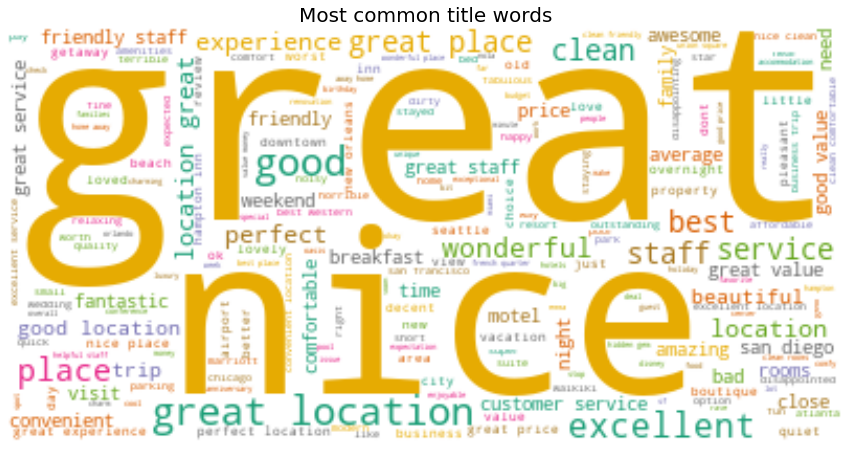

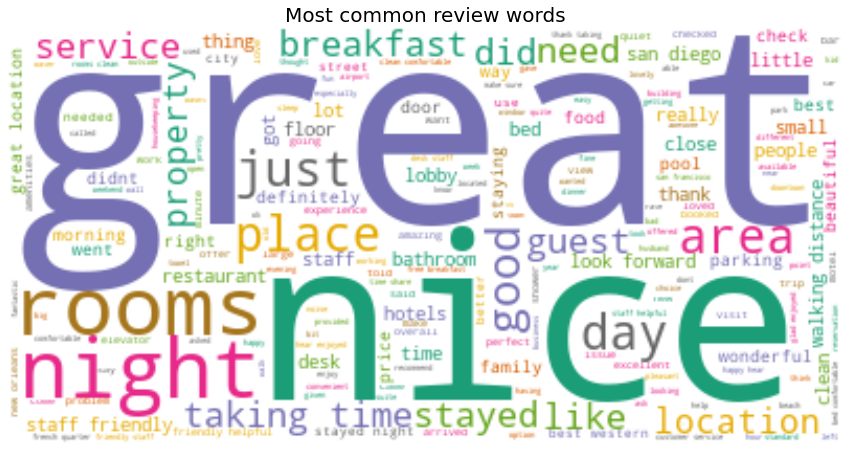

In [39]:
from wordcloud import WordCloud
wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)
title = '' 
text = ''
for idx, row in reviews.iterrows():
    title += f" {row.title}"
    text += f" {row.text}"
title_cleaned = []
for x in title.split():
    if x not in stop_words:
        title_cleaned.append(x)
title_cleaned = " ".join(title_cleaned)
text_cleaned = []
for x in text.split():
    if x not in stop_words:
        text_cleaned.append(x)
text_cleaned = " ".join(text_cleaned)

plt.figure(figsize=(15, 20))
wc.generate(title_cleaned)
plt.imshow(wc, interpolation="bilinear")
plt.title("Most common title words", fontsize = 20)
plt.axis("off")

plt.figure(figsize=(15, 20))
wc.generate(text_cleaned)
plt.imshow(wc, interpolation="bilinear")
plt.title("Most common review words", fontsize = 20)
plt.axis("off")

In [40]:
from textblob import TextBlob

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity


reviews['title_polarity'] = reviews['title'].apply(pol)
reviews['title_subjectivity'] = reviews['title'].apply(sub)

reviews['text_polarity'] = reviews['text'].apply(pol)
reviews['text_subjectivity'] = reviews['text'].apply(sub)
reviews.head()

,name,rating,title,text,city,province,categories,title_polarity,title_subjectivity,text_polarity,text_subjectivity
0,Best Western Plus South Coast Inn,3,best western plus hotel,this hotel was nice and quiet did not know the...,Goleta,CA,"Hotels,Hotels and motels,Hotel and motel mgmt....",0.500000,0.15,0.187500,0.407292
1,Best Western Carmel's Town House Lodge,4,clean rooms at solid rates in the heart of carmel,we stayed in the king suite with the separatio...,Carmel by the Sea,CA,"Hotels,Lodging,Hotel",0.183333,0.40,0.399524,0.497143
2,Best Western Carmel's Town House Lodge,3,business,parking was horrible somebody ran into my rent...,Carmel by the Sea,CA,"Hotels,Lodging,Hotel",0.000000,0.00,-0.350000,0.650000
3,Best Western Carmel's Town House Lodge,5,very good,not cheap but excellent location price is some...,Carmel by the Sea,CA,"Hotels,Lodging,Hotel",0.910000,0.78,0.495238,0.714286
4,Best Western Carmel's Town House Lodge,2,low chance to come back here,if you get the room that they advertised on th...,Carmel by the Sea,CA,"Hotels,Lodging,Hotel",0.000000,0.15,0.214286,0.485714


In [41]:
reviews_grouped = reviews.groupby("name").mean()
# reviews_grouped["city"] = reviews.groupby("name")["city"]
# reviews_grouped["province"] = reviews.groupby("name")["province"]
# reviews_grouped["categories"] = reviews.groupby("name")["categories"]

reviews_grouped["total_reviews"] = reviews.groupby("name").count()["rating"]
reviews_grouped.head()


,rating,title_polarity,title_subjectivity,text_polarity,text_subjectivity,total_reviews
name,,,,,,
11th Avenue Hotel Hostel,1.0,0.000000,0.000000,0.143182,0.355303,1
21c Museum Hotel Lexington,2.5,0.315909,0.650000,0.190110,0.487363,2
402 Hotel #Thebigo,4.0,0.500000,0.900000,0.470000,0.680000,1
APPLE Inn,3.0,0.294444,0.516667,0.343750,0.618750,2
Ace Hotel-new Orleans,4.0,0.000000,0.000000,0.344924,0.642008,1


In [42]:
def polarity_binning(x):
    if x < -.4:
        return "Terrible"
    elif x < -.1:
        return "Bad"
    elif x < .1:
        return "Neutral"
    elif x < .5:
        return "Good"
    else:
        return "Great"

get_polarity = lambda x: polarity_binning(x)
reviews_grouped["polarity_bin"] = reviews_grouped.text_polarity.apply(get_polarity)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Text review categories')

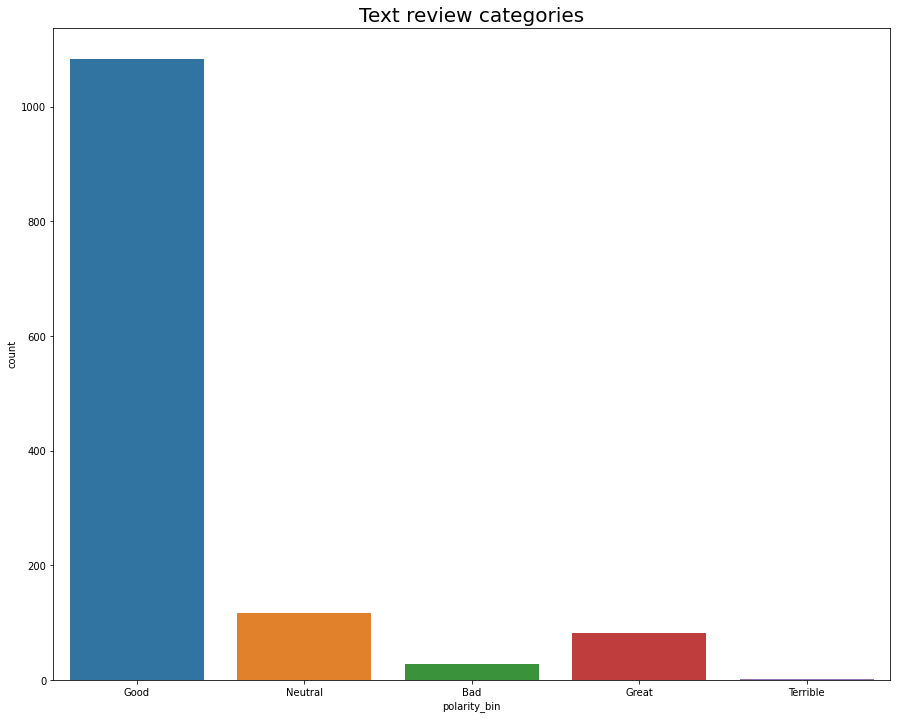

In [43]:
import seaborn as sns
plt.rcParams['figure.figsize'] = [15, 12]
sns.countplot(reviews_grouped.polarity_bin)
plt.title("Text review categories", fontsize = 20)

In [44]:
reviews_grouped["popularity"] = reviews_grouped["rating"] * reviews_grouped["total_reviews"]
reviews_grouped.head()

,rating,title_polarity,title_subjectivity,text_polarity,text_subjectivity,total_reviews,polarity_bin,popularity
name,,,,,,,,
11th Avenue Hotel Hostel,1.0,0.000000,0.000000,0.143182,0.355303,1,Good,1.0
21c Museum Hotel Lexington,2.5,0.315909,0.650000,0.190110,0.487363,2,Good,5.0
402 Hotel #Thebigo,4.0,0.500000,0.900000,0.470000,0.680000,1,Good,4.0
APPLE Inn,3.0,0.294444,0.516667,0.343750,0.618750,2,Good,6.0
Ace Hotel-new Orleans,4.0,0.000000,0.000000,0.344924,0.642008,1,Good,4.0


In [45]:
reviews_grouped[(reviews_grouped.polarity_bin == "Good") & (reviews_grouped.total_reviews > 10)]

,rating,title_polarity,title_subjectivity,text_polarity,text_subjectivity,total_reviews,polarity_bin,popularity
name,,,,,,,,
Aloft Atlanta Downtown,4.066667,0.399111,0.455778,0.250506,0.527634,15,Good,61.0
Aloft New Orleans Downtown,4.263158,0.327536,0.457927,0.276868,0.520406,19,Good,81.0
Anaheim Del Sol Inn,3.989583,0.504592,0.572405,0.232847,0.533903,96,Good,383.0
BEST WESTERN PLUS The Inn At King Of Prussia,4.272727,0.365909,0.415909,0.344935,0.585569,11,Good,47.0
Baymont By Wyndham Florida Mall,2.705882,0.118813,0.483115,0.126820,0.543190,17,Good,46.0
...,...,...,...,...,...,...,...,...
Vagabond Hotel Miami,4.578947,0.418509,0.528333,0.232882,0.520826,19,Good,87.0
W Seattle,3.965517,0.403405,0.516092,0.284203,0.539273,29,Good,115.0
Waikiki Resort Hotel,4.094595,0.425818,0.471280,0.314103,0.557608,74,Good,303.0


Text(0.5, 1.0, 'Total review and polarity correlation')

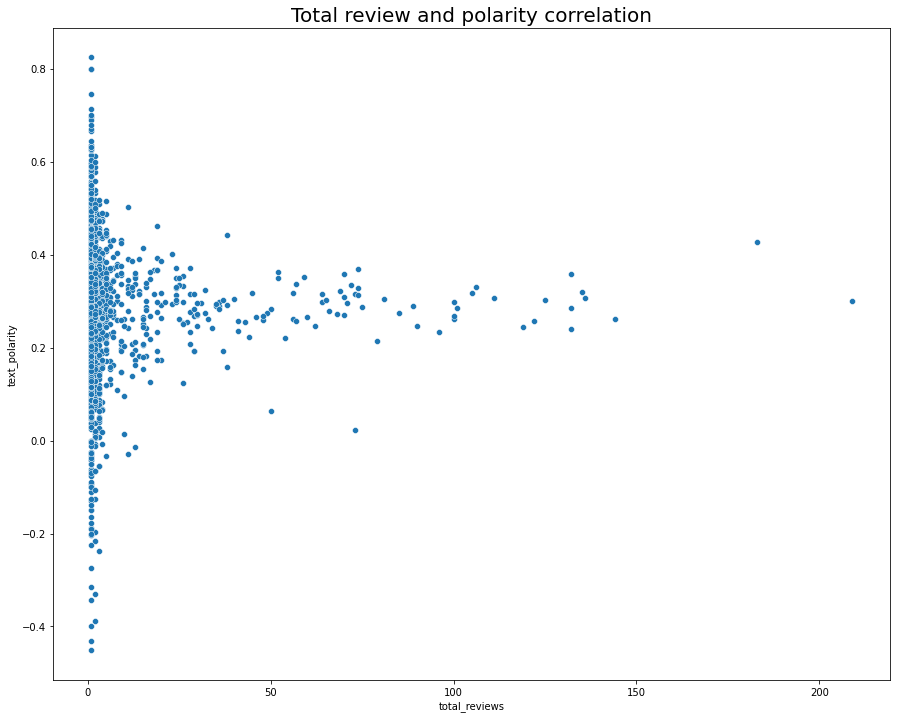

In [46]:
sns.scatterplot(y = "text_polarity", x = "total_reviews", data=reviews_grouped)
plt.title("Total review and polarity correlation", fontsize = 20)

Text(0.5, 1.0, 'Total review and rating correlation')

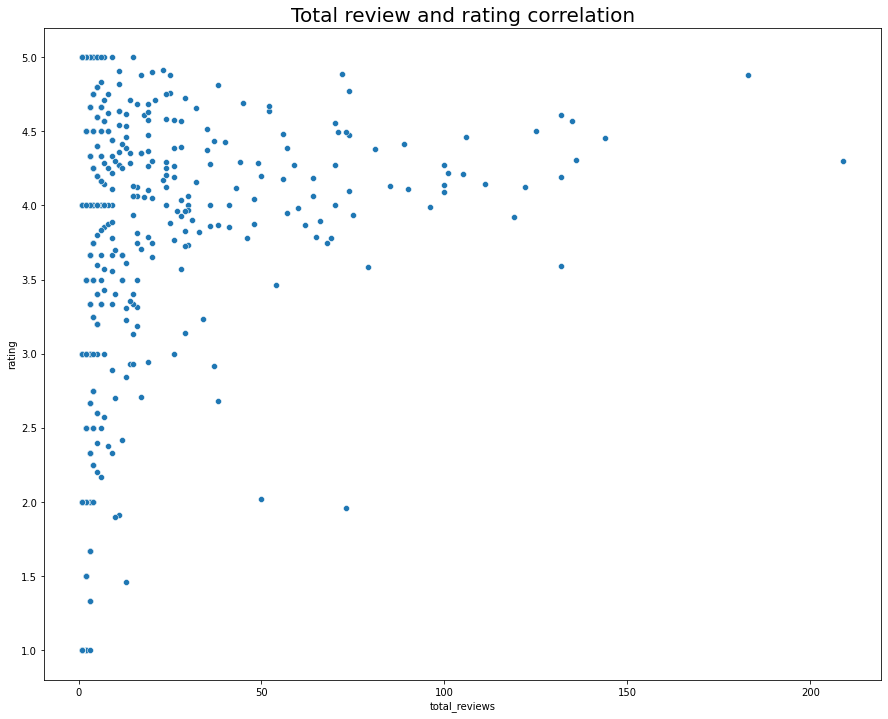

In [47]:
sns.scatterplot(y = "rating", x = "total_reviews", data=reviews_grouped)
plt.title("Total review and rating correlation", fontsize = 20)

Text(0.5, 1.0, 'Text and Title polarity')

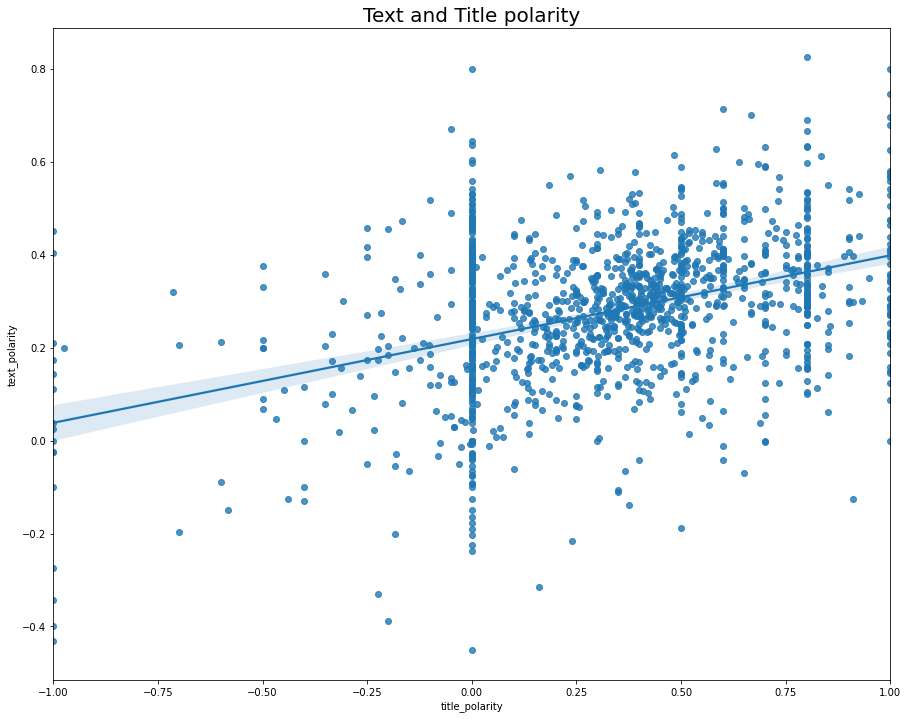

In [48]:
sns.regplot(y = "text_polarity", x = "title_polarity", data=reviews_grouped)
plt.title("Text and Title polarity", fontsize = 20)

In [49]:
reviews_grouped.sort_values("popularity", ascending=False).iloc[0:10]


,rating,title_polarity,title_subjectivity,text_polarity,text_subjectivity,total_reviews,polarity_bin,popularity
name,,,,,,,,
Hyatt House Seattle/Downtown,4.301435,0.400158,0.534760,0.300936,0.577530,209,Good,899.0
Hotel Emma,4.879781,0.388122,0.473633,0.427832,0.662124,183,Good,893.0
French Market Inn,4.458333,0.456771,0.610601,0.262608,0.503730,144,Good,642.0
Grand Hyatt Seattle,4.570370,0.554130,0.640223,0.319393,0.592095,135,Good,617.0
Drury Inn & Suites New Orleans,4.613636,0.534832,0.618138,0.285324,0.565890,132,Good,609.0
"St. James Hotel, an Ascend Hotel Collection Member",4.308824,0.413256,0.569241,0.306639,0.567341,136,Good,586.0
Galleria Park Hotel,4.504000,0.440410,0.565846,0.302260,0.564136,125,Good,563.0
Luana Waikiki Hotel & Suites,4.189394,0.407233,0.589992,0.359590,0.627841,132,Good,553.0
Homewood Suites by Hilton Lake Buena Vista-Orlando,4.122951,0.407428,0.553945,0.256413,0.581580,122,Good,503.0


In [50]:
most_popular = reviews_grouped.sort_values("popularity", ascending=False)
                                  
hotels = reviews_jun.drop_duplicates(subset='name')
filtered_hotels = hotels.filter(["name","address", "postalCode","websites","city","province", "categories"], axis=1)

popularity_list = most_popular.index.to_list()

filtered_hotels = filtered_hotels.set_index("name").reindex(popularity_list)

most_popular_filtered = filtered_hotels.loc[filtered_hotels["city"]==city].loc[filtered_hotels["province"]==province].iloc[0:5]
most_popular_filtered

,address,postalCode,websites,city,province,categories
name,,,,,,
Best Western Seven Seas,411 Hotel Cir S,92108,https://www.bestwestern.com/en_US/book/hotel-r...,San Diego,CA,"Hotels,Restaurant,Lodging,Hotels Motels,Accomm..."
Hampton Inn San Diego Del Mar,11920 El Camino Real,92130,http://hamptoninn3.hilton.com/en/hotels/califo...,San Diego,CA,"Hotels Motels,Hotel"
Ocean Park Inn,710 Grand Ave,92109,"https://oceanparkinn.com/,https://oceanparkinn...",San Diego,CA,"Hotels and motels,Hotel"
The Pearl Hotel,1410 Rosecrans St,92106,http://www.thepearlsd.com/,San Diego,CA,"Hotels,Cocktail Bar,Hotels Motels,Hotel,Movie ..."
Best Western Plus Bayside Inn,555 W Ash St,92101,https://www.bestwestern.com/en_US/book/hotel-r...,San Diego,CA,"Corporate Housing,Budget Hotels,Tourist Hotels..."


In [51]:
!pip install ipywidgets

In [52]:
import ipywidgets as widgets
from IPython.display import display

In [53]:
#main UI dashboard

item_layout = widgets.Layout(margin='0 50px 50px 50px')

title = widgets.Label(value="Welcome to the Hotel Recommendation System!",layout=item_layout )
method_title = widgets.Label(value="Choose a recommendation method:",layout=item_layout )
type_of_method = widgets.ToggleButtons(options=["Review Based", "ID Based"], value= "ID Based", layout=item_layout)


id_title = widgets.Label(value="If using ID Based method, input your USER ID\n\n",layout=item_layout )
user_id_input = widgets.Text(description="USER ID : ", width=200, layout=item_layout, value='47')

places = reviews_jun['city']+"," + reviews_jun['province']
places = places.drop_duplicates().sort_values().tolist()

city_input = widgets.Dropdown(options=places, value=places[0],description="Select city:", layout=item_layout)
n_outputs = widgets.IntSlider(value=1,min=1,max=5,step=1,description="Hotels:", layout=item_layout)
search_button = widgets.Button(description="SEARCH")

display(title)
display(method_title)
display(type_of_method)
display(id_title)
display(user_id_input)

display(city_input)
display(n_outputs)
display(search_button)

output = widgets.Output()
display(output)

def search_clicked(change):
  output.clear_output()
  with output:
    
    print("Input Parameters")
    print("method: %s" % type_of_method.value)
    print("user id: %s" % user_id_input.value)
    input_city,input_province = city_input.value.split(",")
    print("city: %s" % input_city)
    print("province: %s" % input_province)
    print("number of hotels: %s" % n_outputs.value)

    
    if type_of_method.value == "ID Based":
      
      # code to execute of ID based chosen
      # code to execute of ID based chosen
      recommended_hotels = recommendate_topn_hotels_for_user(reviews_jun, all_pred_sorted, int(user_id_input.value), input_city, input_province, topn=n_outputs.value)
      recommended_hotels = recommended_hotels.set_index("name").drop(columns=["primaryCategories","country","reviews.rating","id"]).reindex(columns=["address","postalCode","websites","city","province","categories"])
      display(recommended_hotels)
      
    else:
      # code to execute of review based chosen
      most_popular_filtered = filtered_hotels.loc[filtered_hotels["city"]==input_city].loc[filtered_hotels["province"]==input_province].iloc[0:n_outputs.value]
      display(most_popular_filtered)



      
search_button.on_click(search_clicked)

Label(value='Welcome to the Hotel Recommendation System!', layout=Layout(margin='0 50px 50px 50px'))

Label(value='Choose a recommendation method:', layout=Layout(margin='0 50px 50px 50px'))

ToggleButtons(index=1, layout=Layout(margin='0 50px 50px 50px'), options=('Review Based', 'ID Based'), value='…

Label(value='If using ID Based method, input your USER ID\n\n', layout=Layout(margin='0 50px 50px 50px'))

Text(value='47', description='USER ID : ', layout=Layout(margin='0 50px 50px 50px'))

Dropdown(description='Select city:', layout=Layout(margin='0 50px 50px 50px'), options=('Aberdeen,MD', 'Abilen…

IntSlider(value=1, description='Hotels:', layout=Layout(margin='0 50px 50px 50px'), max=5, min=1)

Button(description='SEARCH', style=ButtonStyle())

Output()